In [1]:
from final_functions import *

### (Opcional) Extracción de frames

In [2]:
# video_path = '/Users/diegosilveracoeff/Downloads/Video_Rami.mp4'
# output_folder = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain'
video_path = '/Users/diegosilveracoeff/Downloads/Lana_Lucho.mp4'
output_folder = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho'
#video_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/Lana_Lucho.mp4'
frame_nums = [32, 33]  # Números de frames que deseas extraer


extract_frames(video_path, frame_nums, output_folder)

Frame 32 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/frame_32.tif
Frame 33 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/frame_33.tif


### Defino rutas de trabajo y cargo imágenes

En las siguientes celdas se importan la imagen de referencia y la imagen objetivo

Valor mínimo de diferencia:  -213
Valor máximo de diferencia:  197
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/residual_frame.tif


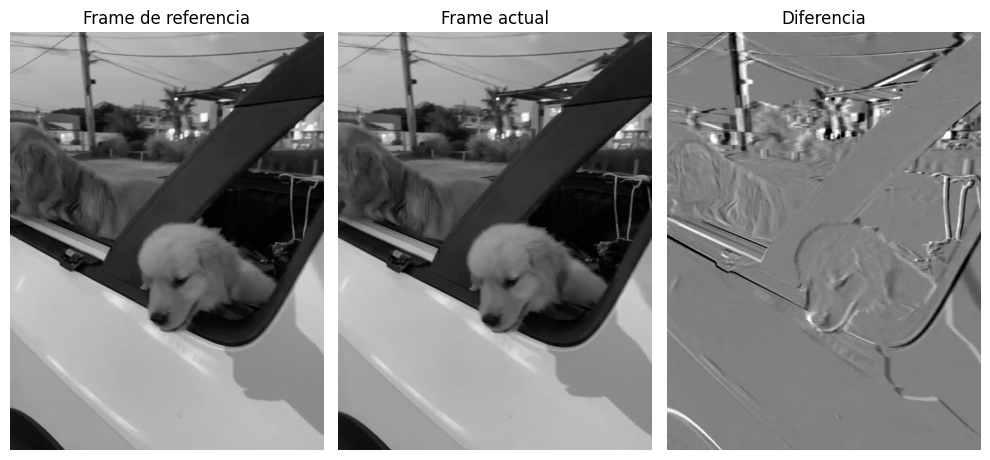

In [3]:
folder_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho' #Cambiar por path de trabajo
reference_frame_path = os.path.join(folder_path, 'frame_32.tif')
current_frame_path = os.path.join(folder_path, 'frame_33.tif')
residual_1_path = os.path.join(folder_path, 'residual_frame.tif')

tittles = ['Frame de referencia','Frame actual','Diferencia']

def subtract_frames_2(current_frame_path, reference_frame_path, output_path, clip=True):
    '''
    Función que lee dos imágenes, hace la diferencia, clippea el resultado para guardar en 8 bits y lo guarda en un path especificado
    INPUT: Video file, list with frames indexes, output folder
    OUTPUT: None
    '''
    # Lee las imágenes
    img1 = cv2.imread(current_frame_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)
    img2 = cv2.imread(reference_frame_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)

    # Verifica si las imágenes se leyeron correctamente
    if img1 is None or img2 is None:
        print("Error al leer las imágenes.")
        return

    # Realiza la resta de las imágenes
    diff_img = img1 - img2
    #diff_img = diff_img.astype(np.int16)

    #Verifico el rango dinámico de la diferencia
    print('Valor mínimo de diferencia: ', np.min(diff_img))
    print('Valor máximo de diferencia: ', np.max(diff_img))

    # Guarda la imagen resultante como PNG
    cv2.imwrite(output_path, diff_img, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
    print(f"Resultado de la resta ajustado y guardado como {output_path}")

    return

subtract_frames(current_frame_path, reference_frame_path, residual_1_path, clip=True)

plot_three_images(reference_frame_path, current_frame_path, residual_1_path, tittles)

(1280, 960, 2)
flow_x guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/flow_x.npy
flow_y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/flow_y.npy
Visualización del flujo óptico guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/optical_flow_visualization.png


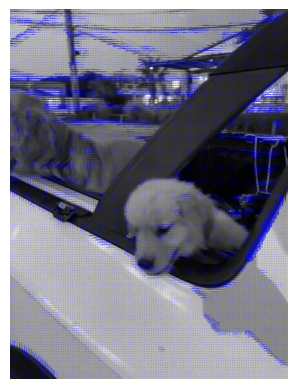

In [4]:
#Calculo el flujo óptico entre el frame de referencia y el frame actual

optical_flow(current_frame_path, reference_frame_path, folder_path)

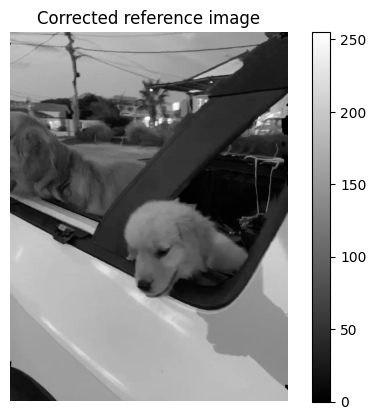

In [5]:
#Cargo el flujo óptico y hago motion_compensation

flow_x_path = os.path.join(folder_path, 'flow_x.npy')
flow_y_path = os.path.join(folder_path, 'flow_y.npy')

corrected_reference_path = os.path.join(folder_path, 'corrected_reference.tif')
motion_compensation_2(reference_frame_path, current_frame_path, flow_x_path, flow_y_path, corrected_reference_path)

Valor mínimo de diferencia:  -191
Valor máximo de diferencia:  218
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/residual_2.tif


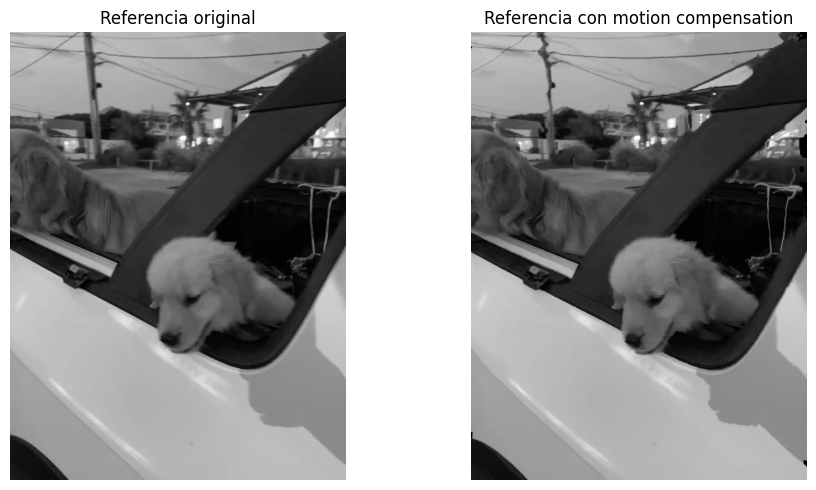

In [6]:
#Celda de control, en las gaussianas sintéticas debería obtener 0s

residual_2_path = os.path.join(folder_path, 'residual_2.tif')
subtract_frames(corrected_reference_path, current_frame_path, residual_2_path)

plot_two_images(reference_frame_path, corrected_reference_path, ['Referencia original', 'Referencia con motion compensation'])

La energía de residual_frame.tif es 466873368
La energía de residual_2.tif es 473924925


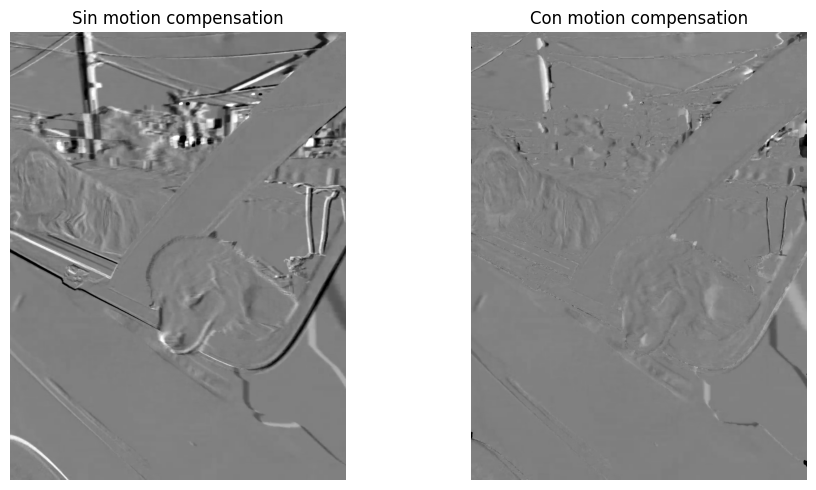

In [7]:
#Celda de control, la energía del residual que se calculó teniendo en cuentra 
#el motion_compensation debe ser menor.

energy(residual_1_path)
energy(residual_2_path)

plot_two_images(residual_1_path,residual_2_path, ['Sin motion compensation','Con motion compensation'])

### Transformada coseno y cuantización

In [8]:
#Calculo la DCT del residual y cuantizo

dct_path = os.path.join(folder_path, 'DCT.tif')
q_path = os.path.join(folder_path, 'quantized_image.tif')

dct_image = dct_2(residual_2_path, dct_path)
q_image, q_array = quantization(dct_image, 50, q_path)

#print(q_array)

#plot_one_img(dct_path)

In [9]:
reordered_array = reorder_array(q_array)

print(reordered_array)


[(  0, 1050, 0) (  7, 1050, 0) (  7, 1000, 0) ... (  7, 1000, 0)
 (  7, 1000, 0) (143,   50, 1)]


In [10]:
#Calculo la probabilidad de ocurrencia de cada valor de la DCT cuantizada y armo el codebook

count = count_pixel_values(reordered_array)
print(count)
print(len(count))
symbols, codes = huffman_codebook(count)

np.save(os.path.join(folder_path,'symbols.npy'), symbols)
print(f"symbols guardados como {os.path.join(folder_path,'symbols.npy')}")
np.save(os.path.join(folder_path,'codes.npy'), codes)
print(f"codes guardado como {os.path.join(folder_path,'codes.npy')}")

[('(0, -450, 0)', 2), ('(0, -400, 0)', 1), ('(0, -350, 0)', 4), ('(0, -300, 0)', 2), ('(0, -250, 0)', 14), ('(0, -200, 0)', 16), ('(0, -150, 0)', 64), ('(0, -100, 0)', 172), ('(0, -50, 0)', 1347), ('(0, 50, 0)', 1289), ('(0, 100, 0)', 178), ('(0, 150, 0)', 62), ('(0, 200, 0)', 34), ('(0, 250, 0)', 17), ('(0, 300, 0)', 13), ('(0, 350, 0)', 3), ('(0, 400, 0)', 7), ('(0, 650, 0)', 1), ('(0, 1000, 0)', 7), ('(0, 1050, 0)', 6), ('(0, 1100, 0)', 1), ('(1, -150, 0)', 1), ('(1, -100, 0)', 11), ('(1, -50, 0)', 179), ('(1, 50, 0)', 183), ('(1, 100, 0)', 6), ('(1, 150, 0)', 4), ('(1, 200, 0)', 1), ('(1, 250, 0)', 1), ('(1, 950, 0)', 1), ('(1, 1000, 0)', 3), ('(1, 1050, 0)', 5), ('(1, 1100, 0)', 6), ('(1, 1200, 0)', 1), ('(2, -150, 0)', 2), ('(2, -50, 0)', 32), ('(2, 50, 0)', 23), ('(2, 100, 0)', 2), ('(2, 500, 0)', 1), ('(2, 850, 0)', 3), ('(2, 950, 0)', 1), ('(2, 1000, 0)', 8), ('(2, 1050, 0)', 5), ('(2, 1100, 0)', 2), ('(2, 1150, 0)', 1), ('(3, -250, 0)', 1), ('(3, -50, 0)', 12), ('(3, 50, 0)',

In [11]:
#Sustituyo cada símbolo por su código y escribo el archivo con el fillout_number

bin_path = os.path.join(folder_path, 'message.bin')
write_encoded_file_2(reordered_array, symbols, codes, bin_path)

Largo de la imagen codificada (mensaje) 106648
Fillout_number:  0
0000000001110001001010111110101110101010111110101010111110010101111111100100001010110100001010111011101010101010101010100110001100101010101111111111111110101010101010100110001100101001100011000110010100110001100001101001100011001010101001010111101100011010011000100001010111010101001100011001010011000110001100011000110001100101010101010101010101010011000101001000001001010111011010100010100111000101011000000110111001000011011011011010000010001001000011100001100100110000011101000010000101010000100111010010101110000101000010010001110110000101000010101000111011100110000110001111110010000110000110000110001011010111001000011100110010101000011111011101101010001000100111100110001110110010101001001010011010000001101010011111010000011000111010011010010000011111110000001100001100001100001100001100001001000000110111000001001000010101010011011000001000001011000000111111000110010001100111000010000000000011000101101010010001100000000000